In [28]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import utils
import algo
import pickle
import tensorly as tl
from numpy import linalg as LA
from scipy.stats import zscore, pearsonr
from scipy.io import savemat, loadmat
%matplotlib widget

In [29]:
# load .mat data from data/OneShot/time_modes.mat
# sources_cpd = loadmat('data/OneShot/time_modes_5.mat')['time_modes_5']
sources_cpd = loadmat('data/OneShot/ll1_sources_5_10_15_20_20.mat')['sources']
eeg_multisub = loadmat('data/OneShot/eeg_multisub.mat')['eeg_multisub']
fs = 30
T, D, N = eeg_multisub.shape
_, K = sources_cpd.shape
with open('data/OneShot/features.pkl', 'rb') as f:
    features_list = pickle.load(f)
features = np.concatenate(tuple(features_list), axis=0)
objflow = features[:, 8]

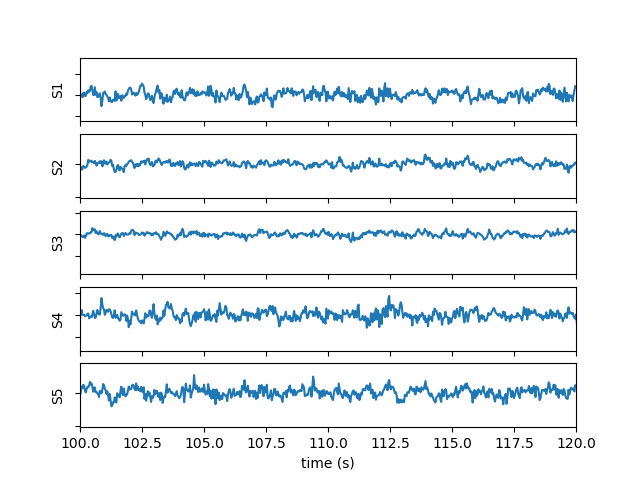

In [30]:
# plot the sources in subplots, each column is a source, all subplots share the same time axis
plt.close()
time = np.arange(T)/30
fig, axs = plt.subplots(K, 1, sharex=True)
for i in range(K):
    axs[i].plot(time, sources_cpd[:,i])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('S{}'.format(i+1))
# show 20 seconds
plt.xlim([100, 120])
plt.xlabel('time (s)')
plt.show()

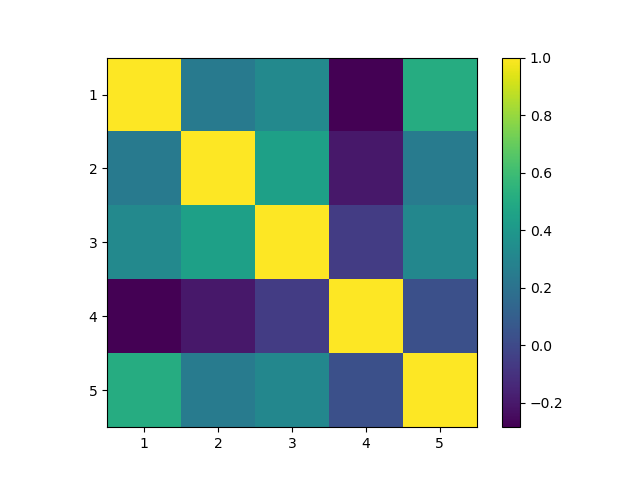

In [31]:
# calculate the correlations between the sources
corr_sources = np.corrcoef(sources_cpd.T)
plt.close()
plt.imshow(corr_sources)
plt.colorbar()
# let the ticks start from 1
plt.xticks(np.arange(K), np.arange(K)+1)
plt.yticks(np.arange(K), np.arange(K)+1)
plt.show()

In [32]:
eeg_list = [eeg_multisub[:,:,n] for n in range(N)]
eeg_concat_sub = np.concatenate(tuple(eeg_list), axis=0)
source_list = [sources_cpd for n in range(N)]
source_concat_sub = np.concatenate(tuple(source_list), axis=0)

In [33]:
# find F, where source_concat_sub * F^T = eeg_concat_sub
F = np.linalg.lstsq(source_concat_sub, eeg_concat_sub, rcond=None)[0].T
forward_model = (LA.inv(source_concat_sub.T @ source_concat_sub) @ source_concat_sub.T @ eeg_concat_sub).T
# Varified: they are the same

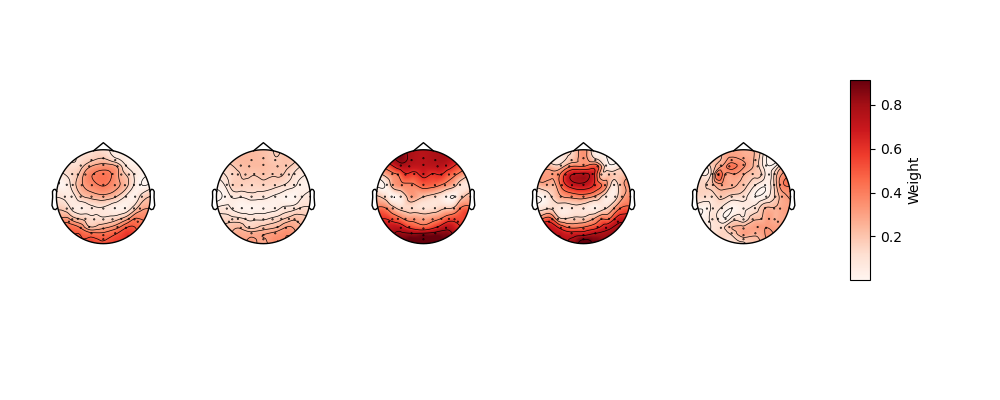

In [34]:
plt.close()
_, n_components = forward_model.shape
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
vmax = np.max(np.abs(forward_model))
vmin = np.min(np.abs(forward_model))
if n_components < 5:
    n_row = 1
    n_column = n_components
else:
    if n_components % 5 != 0:
        n_row = n_components//5 + 1
    else:
        n_row = n_components//5
    n_column = 5
fig, axes = plt.subplots(nrows=n_row, ncols=n_column, figsize=(10, 4*n_row))
fig.tight_layout()
fig.subplots_adjust(right=0.8)
comp = 0
for ax in axes.flat:
    if comp < n_components:
        im, _ = mne.viz.plot_topomap(np.abs(forward_model[:,comp]), create_info, ch_type='eeg', axes=ax, show=False, vlim=(vmin, vmax))
    else:
        ax.axis('off')
    comp += 1
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, label='Weight')
plt.show()

### CCA

In [35]:
CCA = algo.CanonicalCorrelationAnalysis([sources_cpd], [objflow], fs, L_EEG=3, L_Stim=int(fs/2), offset_EEG=1, offset_Stim=0, signifi_level=True, n_components=2)
_, corr_test, sig_corr, _, _, _, _, V_A_train, V_B_train = CCA.cross_val()

100%|██████████| 1000/1000 [00:01<00:00, 858.95it/s]

Significance level: 0.01881214878476628
Average correlation coefficients of the top 2 components on the training sets: [0.04743705 0.03355102]
Average correlation coefficients of the top 2 components on the test sets: [0.04132515 0.02907619]


In [36]:
for k in range(K):
    source = sources_cpd[:,k]
    source = np.expand_dims(source, axis=1)
    CCA = algo.CanonicalCorrelationAnalysis([source], [objflow], fs, L_EEG=3, L_Stim=int(fs/2), offset_EEG=1, offset_Stim=0, signifi_level=True, n_components=2)
    _, corr_test, sig_corr, _, _, _, _, V_A_train, V_B_train = CCA.cross_val()

100%|██████████| 1000/1000 [00:01<00:00, 926.78it/s]


Significance level: 0.018988030044371686
Average correlation coefficients of the top 2 components on the training sets: [0.03797941 0.0191626 ]
Average correlation coefficients of the top 2 components on the test sets: [0.03689822 0.00973835]


100%|██████████| 1000/1000 [00:01<00:00, 834.37it/s]


Significance level: 0.01948231682618736
Average correlation coefficients of the top 2 components on the training sets: [0.02847002 0.01335451]
Average correlation coefficients of the top 2 components on the test sets: [0.02506    0.00694032]


100%|██████████| 1000/1000 [00:01<00:00, 875.28it/s]


Significance level: 0.01926504387324057
Average correlation coefficients of the top 2 components on the training sets: [0.02572946 0.01097919]
Average correlation coefficients of the top 2 components on the test sets: [0.02445488 0.00209732]


100%|██████████| 1000/1000 [00:01<00:00, 888.84it/s]


Significance level: 0.018284542227327553
Average correlation coefficients of the top 2 components on the training sets: [0.01648769 0.01110542]
Average correlation coefficients of the top 2 components on the test sets: [0.00918143 0.00047831]


100%|██████████| 1000/1000 [00:01<00:00, 812.34it/s]

Significance level: 0.018430411409750696
Average correlation coefficients of the top 2 components on the training sets: [0.01931355 0.0136753 ]
Average correlation coefficients of the top 2 components on the test sets: [ 0.013073  -0.0009756]


### GCCA versus CPD

In [37]:
def pipe_GCCA_backward(nested_datalist, fs=30, fold=5, n_components=5, trials=False):
    corr_ind = []
    corr_group = []
    algorithm = algo.GeneralizedCCA(nested_datalist[0], fs, L=5, offset=2, fold=fold, n_components=n_components, signifi_level=True, message=True, trials=trials, crs_val=False)
    train_list, test_list, _, _ = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=fold)
    W_train, S, _, _ = algorithm.fit(train_list[0])
    for comp in range(n_components):
        nth_component = S[:, comp]
        LS = algo.LeastSquares(nth_component, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(nth_component, train_list[1])
        test_trans = np.mean(algorithm.get_transformed_data(test_list[0], W_train), axis=2)
        _, filtered_EEG = LS.decoder(test_trans[:, comp], test_list[1], W_b=Wb_train)
        corr_ind.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    for comp in range(1, n_components+1):
        ncomponents = S[:, :comp]
        LS = algo.LeastSquares(ncomponents, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(ncomponents, train_list[1])
        test_trans = np.mean(algorithm.get_transformed_data(test_list[0], W_train), axis=2)
        _, filtered_EEG = LS.decoder(test_trans[:, :comp], test_list[1], W_b=Wb_train)
        corr_group.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    return corr_ind, corr_group

In [38]:
def pipe_CPD_backward(nested_datalist, source_list, fs=30, fold=5, n_components=5):
    corr_ind = []
    corr_group = []
    train_list, test_list, _, _ = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=fold)
    S_train_list, S_test_list, _, _ = utils.split_mm_balance([source_list], fold=fold, fold_idx=fold)
    for comp in range(n_components):
        nth_component = S_train_list[0][:, comp]
        LS = algo.LeastSquares(nth_component, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(nth_component, train_list[1])
        _, filtered_EEG = LS.decoder(S_test_list[0][:, comp], test_list[1], W_b=Wb_train)
        corr_ind.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    for comp in range(1, n_components+1):
        ncomponents = S_train_list[0][:, :comp]
        LS = algo.LeastSquares(ncomponents, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(ncomponents, train_list[1])
        _, filtered_EEG = LS.decoder(S_test_list[0][:, :comp], test_list[1], W_b=Wb_train)
        corr_group.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    return corr_ind, corr_group

In [39]:
nested_datalist = [[eeg_multisub], [objflow]]
GCCA_corr_ind, GCCA_corr_group = pipe_GCCA_backward(nested_datalist, fs=30, fold=5, n_components=K)
CPD_corr_ind, CPD_corr_group = pipe_CPD_backward(nested_datalist, [sources_cpd], fs=30, fold=5, n_components=K)

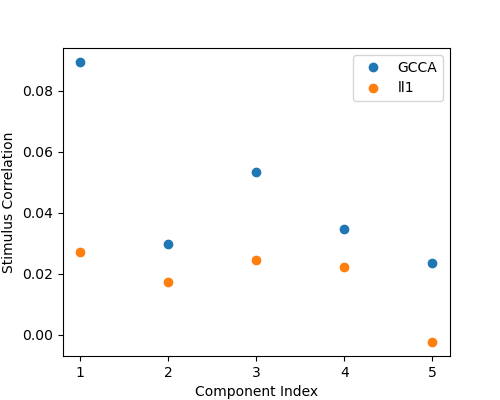

In [40]:
# plot the the results of gcca and cpd in one figure
# Use points instead of lines to show the results
plt.close()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(1, K+1), GCCA_corr_ind, 'o', label='GCCA')
plt.plot(np.arange(1, K+1), CPD_corr_ind, 'o', label='ll1')
plt.xlabel('Component Index')
plt.ylabel('Stimulus Correlation')
plt.xticks(np.arange(1, K+1))
plt.legend()
plt.show()

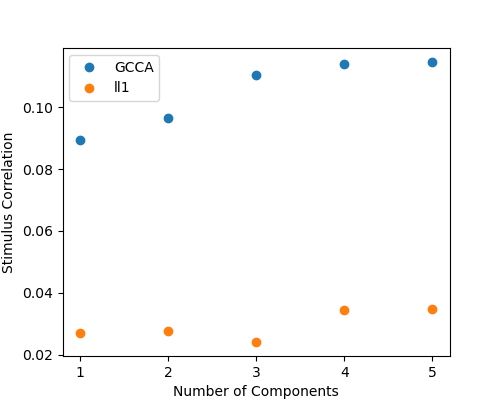

In [41]:
# plot the the results of gcca and cpd in one figure
# Use points instead of lines to show the results
plt.close()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(1, K+1), GCCA_corr_group, 'o', label='GCCA')
plt.plot(np.arange(1, K+1), CPD_corr_group, 'o', label='ll1')
plt.xlabel('Number of Components')
plt.ylabel('Stimulus Correlation')
plt.xticks(np.arange(1, K+1))
plt.legend()
plt.show()

## CPD after GCCA
Removed the dependency on Tensorlab. Now using tensorly.

In [42]:
n_components = 3

In [43]:
# Prepare preprocessed data (the transformed eeg using GCCA filters)
nested_datalist = [[eeg_multisub], [objflow]]
algorithm = algo.GeneralizedCCA(nested_datalist[0], fs, L=5, offset=2, fold=5, n_components=n_components, signifi_level=True, message=True, trials=False, crs_val=False)
train_list, test_list, _, _ = utils.split_mm_balance(nested_datalist, fold=5, fold_idx=5)
W_train, S, _, _ = algorithm.fit(train_list[0])
X_trans_train = algorithm.get_transformed_data(train_list[0], W_train)
X_trans_test = algorithm.get_transformed_data(test_list[0], W_train)
# Transpose the data to fit the tensorly package
X_trans_train_T = np.transpose(X_trans_train, [1,2,0])
X_trans_test_T = np.transpose(X_trans_test, [1,2,0])
T_test = X_trans_test_T.shape[2]

In [44]:
# Perform CPD on the transformed data
# First on the training data, then use the first T_test time points of the training data as the initial value for the test data
# Fix the channel and subject modes
weights, factors_train = tl.decomposition.parafac(X_trans_train_T, rank=n_components)
factors_init = [factors_train[0], factors_train[1], factors_train[2][0:T_test,:]]
_, factors_test = tl.decomposition.parafac(X_trans_test_T, rank=n_components, init=(weights, factors_init), fixed_modes=[0,1])
# Obtain the eeg sources determined by the CPD
S_CPD = np.concatenate((factors_train[2], factors_test[2]), axis=0)

In [45]:
# Alternatively, concatenate the training and test transformed data, then perform CPD on the concatenated data
# Might have informaton leakage from training to test
# X_trans_T = np.concatenate((X_trans_train_T, X_trans_test_T), axis=2)
# weights, factors = tl.decomposition.parafac(X_trans_T, rank=n_components)
# S_CPD = factors[2]

In [46]:
def pipe_GCCA_CPD(nested_datalist, fs=30, fold=5, n_components=5):
    corr_ind = []
    corr_group = []
    train_list, test_list, _, _ = utils.split_mm_balance(nested_datalist, fold=fold, fold_idx=fold)
    for comp in range(n_components):
        nth_component = train_list[0][:, comp]
        LS = algo.LeastSquares(nth_component, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(nth_component, train_list[1])
        _, filtered_EEG = LS.decoder(test_list[0][:, comp], test_list[1], W_b=Wb_train)
        corr_ind.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    for comp in range(1, n_components+1):
        ncomponents = train_list[0][:, :comp]
        LS = algo.LeastSquares(ncomponents, train_list[1], fs, decoding=True, L_EEG=10, offset_EEG=8)
        Wb_train, _ = LS.decoder(ncomponents, train_list[1])
        _, filtered_EEG = LS.decoder(test_list[0][:, :comp], test_list[1], W_b=Wb_train)
        corr_group.append(pearsonr(np.squeeze(filtered_EEG), np.squeeze(test_list[1]))[0])
    return corr_ind, corr_group

In [47]:
nested_datalist = [[S_CPD], [objflow]]
GCCA_CPD_corr_ind, GCCA_CPD_corr_group = pipe_GCCA_CPD(nested_datalist, fs=30, fold=5, n_components=n_components)


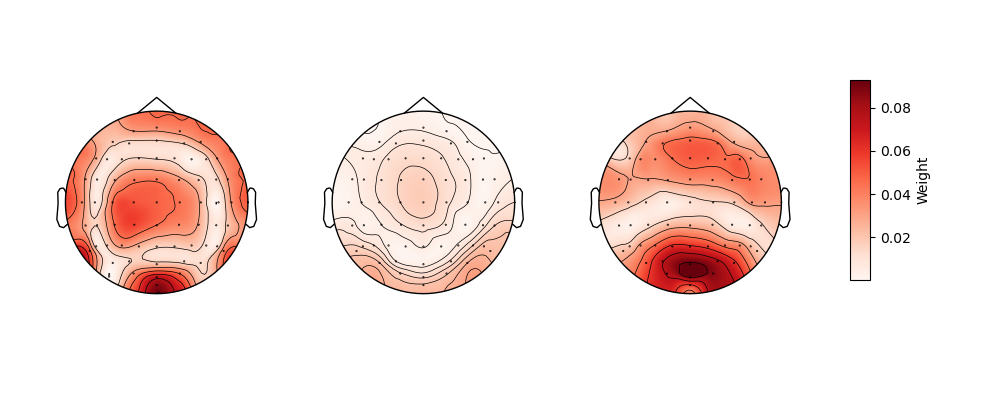

In [48]:
# Calculate the forward model
source_list = [S_CPD for n in range(N)]
source_concat_sub = np.concatenate(tuple(source_list), axis=0)
F = np.linalg.lstsq(source_concat_sub, eeg_concat_sub, rcond=None)[0].T
forward_model = (LA.inv(source_concat_sub.T @ source_concat_sub) @ source_concat_sub.T @ eeg_concat_sub).T

plt.close()
_, n_components = forward_model.shape
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
vmax = np.max(np.abs(forward_model))
vmin = np.min(np.abs(forward_model))
if n_components < 5:
    n_row = 1
    n_column = n_components
else:
    if n_components % 5 != 0:
        n_row = n_components//5 + 1
    else:
        n_row = n_components//5
    n_column = 5
fig, axes = plt.subplots(nrows=n_row, ncols=n_column, figsize=(10, 4*n_row))
fig.tight_layout()
fig.subplots_adjust(right=0.8)
comp = 0
for ax in axes.flat:
    if comp < n_components:
        im, _ = mne.viz.plot_topomap(np.abs(forward_model[:,comp]), create_info, ch_type='eeg', axes=ax, show=False, vlim=(vmin, vmax))
    else:
        ax.axis('off')
    comp += 1
cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, label='Weight')
plt.show()

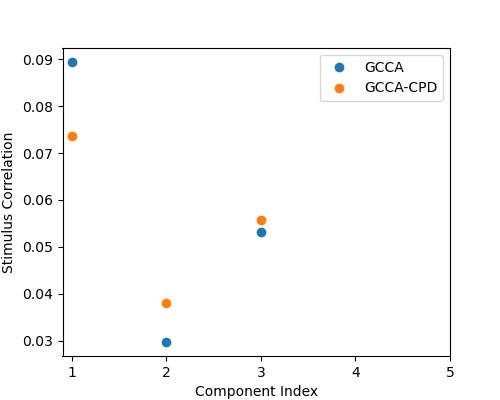

In [51]:
plt.close()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(1, n_components+1), GCCA_corr_ind[:n_components], 'o', label='GCCA')
plt.plot(np.arange(1, n_components+1), GCCA_CPD_corr_ind, 'o', label='GCCA-CPD')
plt.xlabel('Component Index')
plt.ylabel('Stimulus Correlation')
plt.xticks(np.arange(1, K+1))
plt.legend()
plt.show()

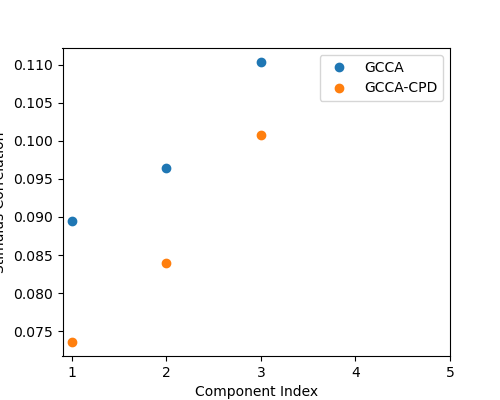

In [52]:
plt.close()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(1, n_components+1), GCCA_corr_group[:n_components], 'o', label='GCCA')
plt.plot(np.arange(1, n_components+1), GCCA_CPD_corr_group, 'o', label='GCCA-CPD')
plt.xlabel('Component Index')
plt.ylabel('Stimulus Correlation')
plt.xticks(np.arange(1, K+1))
plt.legend()
plt.show()